In [18]:
import numpy as np

class SyntheticDataGenerator:

    def __init__(self):
        self.dim_context = 5
        self.num_actions = 40
        self.dim_action = self.dim_context
        self.dim_theta = 15

    def context_vectors(self):
        """Generate context vectors."""

        mean_contextdist = np.array([0,0,0,0,0])
        var_contextdist = np.eye(self.dim_context, self.dim_context)
        #A = np.random.rand(self.dim_context, self.dim_context)
        #var_contextdist = (A.dot(np.transpose(A)))
        return mean_contextdist, var_contextdist
    
    def noisy_contexts(self):
        """Generate context noise parameters."""

        mean_contextnoise_prior =  np.array([0,0,0,0,0])
        #A = np.random.rand(self.dim_context, self.dim_context)
        #B = np.random.rand(self.dim_context, self.dim_context)
        #var_contextnoise = (A.dot(np.transpose(A)))
        #var_contextnoise_prior = (B.dot(np.transpose(B)))
        var_contextnoise_prior = np.eye(self.dim_context, self.dim_context) * 3
        var_contextnoise = np.eye(self.dim_context, self.dim_context) * 3
        return mean_contextnoise_prior, var_contextnoise_prior, var_contextnoise
    
    def action_set(self):
        """Generate action set."""

        mean_action = np.array([0,0,0,0,0])
        var_action = np.eye(self.dim_action, self.dim_action)
        actions = np.random.multivariate_normal(mean_action, var_action, size = self.num_actions)
        return actions
    
    def reward_params(self):
        """Generate reward parameters."""

        mean_theta = np.zeros(self.dim_theta)
        var_theta = 0.01*np.eye(self.dim_theta, self.dim_theta)
        reward_noise_mean = 0
        reward_noise_var = 2
        return mean_theta, var_theta, reward_noise_mean, reward_noise_var
    
    def featuremap(self, context,action):
        """Featuremap to be used in action_choice_noisy."""

        c = context
        a = action
        phi = np.array([a[0]**2,a[1]**2,a[2]**2,a[3]**2,a[4]**2,c[0]**2,c[1]**2,c[2]**2,c[3]**2,c[4]**2,c[0]*a[0],c[1]*a[1],c[2]*a[2],c[3]*a[3],c[4]*a[4]],ndmin=2)
        return phi
    
    def expected_featuremap(self, action,predictedcontext_parameters):
        """Expected featuremap to be used in action_choice."""

        a = action
        m = predictedcontext_parameters[0] #mean vector
        var = predictedcontext_parameters[1] # variance
        c_sq =[var[0][0]+m[0]**2, var[1][1]+m[1]**2,var[2][2]+m[2]**2, var[3][3]+m[3]**2, var[4][4]+m[4]**2]
        phi = np.array([a[0]**2,a[1]**2,a[2]**2,a[3]**2,a[4]**2,c_sq[0],c_sq[1],c_sq[2],c_sq[3],c_sq[4],m[0]*a[0],m[1]*a[1],m[2]*a[2],m[3]*a[3],m[4]*a[4]],ndmin=2)
        return phi


In [19]:
class ParameterFunctions:

    def __init__(self):
        self.synthetic_data = SyntheticDataGenerator()
        self.featuremap = self.synthetic_data.featuremap
        self.expected_featuremap = self.synthetic_data.expected_featuremap

    def parameters_chat_given_gamma (self, gamma, parameters):
        """P(chat|gamma*)."""

        var_contextnoise = parameters[4]
        var_contextdist = parameters[1]
        mean_contextdist =parameters[0]
        var_noise_inv = np.linalg.inv(var_contextnoise)
        var_context_inv = np.linalg.inv(var_contextdist)
        M = var_noise_inv+var_context_inv
        M_inv = np.linalg.inv(M)
        G = var_noise_inv- var_noise_inv.dot(np.linalg.inv(M).T).dot(var_noise_inv)
        G_term2=var_noise_inv.dot(np.linalg.inv(M).T).dot(var_noise_inv)
        F= np.linalg.inv(G).T.dot(G.dot(gamma)+var_noise_inv.dot(M_inv.T).dot(var_context_inv).dot(mean_contextdist))
        output = (F, np.linalg.inv(G))
        return output

    def parameters_gamma_given_contexthist(self, contexthist, ind,parameters):
        """P(gamma*|contexthist)."""

        # contexthist is a numpy array with rows corresponding to past observed contexts
        var_contextnoise = parameters[4]
        var_contextdist = parameters [1]
        var_contextnoise_prior = parameters[3]
        mean_contextdist =parameters[0]
        length = contexthist.shape[0]
        var_noise_inv = np.linalg.inv(var_contextnoise)
        var_context_inv = np.linalg.inv(var_contextdist)
        M = var_noise_inv+var_context_inv
        M_inv = np.linalg.inv(M)
        G = var_noise_inv- var_noise_inv.dot(np.linalg.inv(M).T).dot(var_noise_inv)
        G_inv = np.linalg.inv(G)
        N = np.linalg.inv(var_contextnoise_prior)+G* length
        N_inv = np.linalg.inv(N)
        if ind == 0:
            contexthist = np.array(contexthist,ndmin=2)
        else:
            contexthist = contexthist
        add = np.sum(contexthist,axis = 0)
        
        c= (mean_contextdist.T.dot(var_context_inv).dot(M_inv.T).dot(var_noise_inv)).T*length
        tilde_M = N_inv.T.dot(G.dot(add)-length*var_noise_inv.dot(M_inv.T).dot(var_context_inv).dot(mean_contextdist))
        #a = var_noise_inv+ var_noise_inv.dot(M_inv.T).dot(var_noise_inv) 
        #b = G_inv.dot(G_inv).dot(G_inv.T)
        #add = np.sum(contexthist,axis = 0)
        #d = (add.T.dot(G_inv).dot(G_inv.T).dot(var_noise_inv)).T
        #tilde_M = N_inv.T.dot(a.dot(b).dot(c)+a.dot(d))
        output = (tilde_M, N_inv)
        return output
    
    def parameters_gamma_given_contexthist_delayed(self, contexthist, ind, parameters):
        """P(gamma*|contexthist) for delayed algorithm."""
    
        # contexthist is a numpy array with rows corresponding to past observed contexts
        var_contextnoise = parameters[4]
        var_contextdist = parameters[1]
        var_contextnoise_prior = parameters[3]
        mean_contextdist =parameters[0]
        length = contexthist.shape[0]
        var_noise_inv = np.linalg.inv(var_contextnoise)
        var_context_inv = np.linalg.inv(var_contextdist)
        M = var_noise_inv+var_context_inv
        M_inv = np.linalg.inv(M)
        G = var_noise_inv- var_noise_inv.dot(np.linalg.inv(M).T).dot(var_noise_inv)
        G_inv = np.linalg.inv(G)
        N = np.linalg.inv(var_contextnoise_prior)+G* length
        N_inv = np.linalg.inv(N)
        if ind == 0:
            contexthist = np.array(contexthist,ndmin=2)
        else:
            contexthist = contexthist
        add = np.sum(contexthist,axis = 0)
        
        c= (mean_contextdist.T.dot(var_context_inv).dot(M_inv.T).dot(var_noise_inv)).T*length
        tilde_M = N_inv.T.dot(G.dot(add)-length*var_noise_inv.dot(M_inv.T).dot(var_context_inv).dot(mean_contextdist))
        #a = var_noise_inv+ var_noise_inv.dot(M_inv.T).dot(var_noise_inv) 
        #b = G_inv.dot(G_inv).dot(G_inv.T)
        #add = np.sum(contexthist,axis = 0)
        #d = (add.T.dot(G_inv).dot(G_inv.T).dot(var_noise_inv)).T
        #tilde_M = N_inv.T.dot(a.dot(b).dot(c)+a.dot(d))

        W = length*var_noise_inv + var_contextnoise_prior
        W_inv = np.linalg.inv(W)
        Y = (W_inv).T.dot(var_noise_inv).dot(add) # add has the new context history
        output = (Y, W_inv)
        return output       

    def predicted_context(self, contexthist,chat,ind,parameters):
        """P(c|chat, contexthist)."""

        var_contextnoise = parameters[4]
        mean_contextnoise_prior = parameters[2]
        var_contextdist = parameters [1]
        var_contextnoise_prior = parameters[3]
        mean_contextdist =parameters[0]
        params = self.parameters_gamma_given_contexthist(contexthist,ind,parameters)
        if ind == 1:
            tilde_M = params[0]
            N = np.linalg.inv(params[1])
            var_noise_inv = np.linalg.inv(var_contextnoise)
            var_context_inv = np.linalg.inv(var_contextdist)
            M = var_noise_inv+var_context_inv
            M_inv = np.linalg.inv(M)
            H = var_noise_inv.dot(M_inv.T).dot(var_noise_inv)+N
            H_inv = np.linalg.inv(H)
            D = (M_inv.T).dot(var_context_inv).dot(mean_contextdist)
            E = (M_inv.T).dot(var_noise_inv).dot(chat)
            L = (D+E).T.dot(var_noise_inv)+tilde_M.T.dot(N)
            R = M - var_noise_inv.dot(H_inv.T).dot(var_noise_inv)
            R_inv = np.linalg.inv(R)
            V = R_inv.T.dot(M.dot(D+E)-var_noise_inv.dot(H_inv.T).dot(L.T))
        else:
            tilde_M = mean_contextnoise_prior
            N = var_contextnoise_prior
            var_noise_inv = np.linalg.inv(var_contextnoise)
            var_context_inv = np.linalg.inv(var_contextdist)
            M = var_noise_inv+var_context_inv
            M_inv = np.linalg.inv(M)
            H = var_noise_inv.dot(M_inv.T).dot(var_noise_inv)+N
            H_inv = np.linalg.inv(H)
            D = (M_inv.T).dot(var_context_inv).dot(mean_contextdist)
            E = (M_inv.T).dot(var_noise_inv).dot(chat)
            L = (D+E).T.dot(var_noise_inv)+tilde_M.T.dot(N)
            R = M - var_noise_inv.dot(H_inv.T).dot(var_noise_inv)
            R_inv = np.linalg.inv(R)
            V = R_inv.T.dot(M.dot(D+E)-var_noise_inv.dot(H_inv.T).dot(L.T))
        output =(V, R_inv)
        return output
    
    def predicted_context_delayed(self, contexthist,chat,ind,parameters):
        """P(c|chat, contexthist) for delayed algorithm."""

        var_contextnoise = parameters[4]
        mean_contextnoise_prior = parameters[2]
        var_contextdist = parameters [1]
        var_contextnoise_prior = parameters[3]
        mean_contextdist =parameters[0]
        params = self.parameters_gamma_given_contexthist_delayed(contexthist,ind,parameters)
        if ind == 1:
            #tilde_M = params[0]
            #N = np.linalg.inv(params[1])
            var_noise_inv = np.linalg.inv(var_contextnoise)
            var_context_inv = np.linalg.inv(var_contextdist)
            M = var_noise_inv+var_context_inv
            M_inv = np.linalg.inv(M)
            #H = var_noise_inv.dot(M_inv.T).dot(var_noise_inv)+N
            #H_inv = np.linalg.inv(H)
            D = (M_inv.T).dot(var_context_inv).dot(mean_contextdist)
            E = (M_inv.T).dot(var_noise_inv).dot(chat)
            #L = (D+E).T.dot(var_noise_inv)+tilde_M.T.dot(N)
            #R = M - var_noise_inv.dot(H_inv.T).dot(var_noise_inv)

            # length = contexthist.shape[0]
            # add = np.sum(contexthist,axis = 0)

            # W = length*var_noise_inv + var_contextnoise_prior
            # W_inv = np.linalg.inv(W)
            # Y = (W_inv.T).dot(var_noise_inv).dot(add) # add has the new context history

            # Get from parameters_gamma_given_contexthist_delayed
            Y = params[0]
            W_inv = params[1]
            W = np.linalg.inv(W_inv)

            H_tilde = var_noise_inv.dot(M_inv.T).dot(var_noise_inv) + W
            H_tilde_inv = np.linalg.inv(H_tilde)
            R_tilde = M - var_noise_inv.dot(H_tilde_inv).dot(var_noise_inv)
            R_tilde_inv = np.linalg.inv(R_tilde)
            V_tilde = R_tilde_inv.dot(M.dot(D+E) - var_noise_inv.dot(H_tilde_inv).dot((var_noise_inv.dot(D+E))+W.dot(Y)))
            #V = R_inv.T.dot(M.dot(D+E)-var_noise_inv.dot(H_inv.T).dot(L.T))
        else:
            #tilde_M = mean_contextnoise_prior
            #N = var_contextnoise_prior
            var_noise_inv = np.linalg.inv(var_contextnoise)
            var_context_inv = np.linalg.inv(var_contextdist)
            M = var_noise_inv+var_context_inv
            M_inv = np.linalg.inv(M)
            #H = var_noise_inv.dot(M_inv.T).dot(var_noise_inv)+N
            #H_inv = np.linalg.inv(H)
            D = (M_inv.T).dot(var_context_inv).dot(mean_contextdist)
            E = (M_inv.T).dot(var_noise_inv).dot(chat)
            #L = (D+E).T.dot(var_noise_inv)+tilde_M.T.dot(N)
            #R = M - var_noise_inv.dot(H_inv.T).dot(var_noise_inv)
            #R_inv = np.linalg.inv(R)
            #V = R_inv.T.dot(M.dot(D+E)-var_noise_inv.dot(H_inv.T).dot(L.T))

            # Get from parameters_gamma_given_contexthist_delayed
            Y = mean_contextnoise_prior
            W_inv = var_contextnoise_prior
            W = np.linalg.inv(W_inv)

            H_tilde = var_noise_inv.dot(M_inv.T).dot(var_noise_inv) + W
            H_tilde_inv = np.linalg.inv(H_tilde)
            R_tilde = M - var_noise_inv.dot(H_tilde_inv).dot(var_noise_inv)
            R_tilde_inv = np.linalg.inv(R_tilde)
            V_tilde = R_tilde_inv.dot(M.dot(D+E) - var_noise_inv.dot(H_tilde_inv).dot((var_noise_inv.dot(D+E))+W.dot(Y)))

        output = (V_tilde, R_tilde_inv)
        return output
    
    def predicted_rewardparameter(self, avg_featurehist,rewardhist,parameters):
        """For predicting the reward parameter."""

        reward_noise_var = parameters[9]
        var_theta = parameters[7]
        add_1 = np.zeros(15)
        add_2 = np.zeros((15,15))
        
        for i in range(avg_featurehist.shape[0]):
            phi_ac = np.array(avg_featurehist[i],ndmin=2)
            phi_matrix = phi_ac.T.dot(phi_ac)
            add_1 = add_1 + rewardhist[i]*phi_ac[0]
            add_2 = add_2 + phi_matrix
        V = np.linalg.inv(var_theta)+add_2/reward_noise_var
        min_eig = np.min(np.real(np.linalg.eigvals(V)))
        if min_eig < 0:
            V -= 1e-12 * np.eye(*V.shape)
        
        V_inv = np.linalg.inv(V)
        mean = V_inv.T.dot(add_1)/reward_noise_var
        output = (mean, V_inv)
        return output
    def predicted_rewardparameter_doubleTS(self, avg_featurehist,rewardhist,parameters):
        """For predicting the reward parameter."""

        reward_noise_var = parameters[9]
        var_theta = parameters[7]
        add_1 = np.zeros(15)
        add_2 = np.zeros((15,15))
        
        for i in range(avg_featurehist.shape[0]):
            phi_ac = np.array(avg_featurehist[i],ndmin=2)
            phi_matrix = phi_ac.T.dot(phi_ac)
            add_1 = add_1 + rewardhist[i]*phi_ac[0]
            add_2 = add_2 + phi_matrix
        V = np.linalg.inv(var_theta)+add_2/(reward_noise_var)
        min_eig = np.min(np.real(np.linalg.eigvals(V)))
        if min_eig < 0:
            V -= 1e-12 * np.eye(*V.shape)
        
        V_inv = np.linalg.inv(V)
        mean = V_inv.T.dot(add_1)/(reward_noise_var)
        output = (mean, V_inv)
        return output

    def predicted_rewardparameter_noisy(self, contexthist,rewardhist,actionhist,parameters):
        """For predicting the reward parameter in the noisy case."""

        reward_noise_var = parameters[9]
        var_theta = parameters[7]
        add_1 = np.zeros(15)
        add_2 = np.zeros((15,15))
        
        for i in range(contexthist.shape[0]):
            phi_ac = self.featuremap(contexthist[i],actionhist[i])
            phi_matrix = phi_ac.T.dot(phi_ac)
            add_1 = add_1 + rewardhist[i]*phi_ac[0]
            add_2 = add_2 + phi_matrix
        V = np.linalg.inv(var_theta)+add_2/reward_noise_var
        min_eig = np.min(np.real(np.linalg.eigvals(V)))
        if min_eig < 0:
            V -= 1e-12 * np.eye(*V.shape)
        
        V_inv = np.linalg.inv(V)
        mean = V_inv.T.dot(add_1)/reward_noise_var
        output = (mean, V_inv)
        return output

    def parameters_inverselikelihood(self,chat,gamma,parameters):
        """Further likelihoods."""

        var_contextnoise = parameters[4]
        var_contextdist = parameters [1]
        mean_contextdist =parameters[0]
        var_noise_inv = np.linalg.inv(var_contextnoise)
        var_context_inv = np.linalg.inv(var_contextdist)
        M = var_noise_inv+var_context_inv
        M_inv = np.linalg.inv(M)
        A = M_inv.T.dot(var_context_inv.dot(mean_contextdist)+var_noise_inv.dot((chat-gamma)))
        output = (A, M_inv)
        return output   

    def action_choice(self, theta,actions,predictedcontext_parameters):
        """Agent's action choice."""

        dummy = np.zeros(actions.shape[0])
        for i in range(actions.shape[0]):
            dummy[i] = self.expected_featuremap(actions[i],predictedcontext_parameters).dot(theta)
        max_value = np.max(dummy)
        index = np.argmax(dummy)
        action = actions[index]
        return action
    
    def action_choice_noisy(self, theta,context,actions):
        """Agent's action choice in the noisy case."""

        dummy = np.zeros(actions.shape[0])
        for i in range(actions.shape[0]):
            dummy[i] = self.featuremap(context, actions[i]).dot(theta)
        max_value = np.max(dummy)
        index = np.argmax(dummy)
        action = actions[index]

        return action

    def is_pos_semidef(x):
        return np.all(np.linalg.eigh(x)>= 0)


In [20]:
class AlgorithmsTS:

    def __init__(self, parameters):
        # Get synthetic data
        self.synthetic_data = SyntheticDataGenerator()
        self.featuremap = self.synthetic_data.featuremap
        self.expected_featuremap = self.synthetic_data.expected_featuremap

        # Get parameters functions
        self.parameter_funcs = ParameterFunctions()
        self.parameters_chat_given_gamma = self.parameter_funcs.parameters_chat_given_gamma
        self.parameters_gamma_given_contexthist = self.parameter_funcs.parameters_gamma_given_contexthist
        self.predicted_context = self.parameter_funcs.predicted_context
        self.predicted_rewardparameter = self.parameter_funcs.predicted_rewardparameter
        self.predicted_rewardparameter_noisy = self.parameter_funcs.predicted_rewardparameter_noisy
        self.parameters_inverselikelihood = self.parameter_funcs.parameters_inverselikelihood
        self.action_choice = self.parameter_funcs.action_choice
        self.action_choice_noisy = self.parameter_funcs.action_choice_noisy
        self.is_pos_semidef = self.parameter_funcs.is_pos_semidef

        # Get parameters functions for delayed context
        self.parameters_gamma_given_contexthist_delayed = self.parameter_funcs.parameters_gamma_given_contexthist_delayed
        self.predicted_context_delayed = self.parameter_funcs.predicted_context_delayed

        # Unpack parameters
        self.mean_contextdist =parameters[0]
        self.var_contextdist = parameters[1]
        self.mean_contextnoise_prior = parameters[2]
        self.var_contextnoise_prior = parameters[3]
        self.var_contextnoise = parameters[4]
        self.actions = parameters[5]
        self.mean_theta = parameters[6]
        self.var_theta = parameters[7]
        self.reward_noise_mean = parameters[8]
        self.reward_noise_var = parameters[9]

    def doubleThompsonSampling_denoising(self, num_iters, parameters, context_list,noisycontext_list, theta_seed, gamma_seed):
        """Thompson Sampling with de-noised context."""

        # Histories
        contexthist = np.zeros((num_iters, self.dim_context))
        rewardhist = np.zeros(num_iters)
        actionhist = np.zeros((num_iters, self.dim_action))
        avg_featurehist =np.zeros((num_iters,15))
        per_step_regret = np.zeros(num_iters)
        cum_regrets = np.zeros(num_iters)

        # Generate true theta and gamma
        np.random.seed(theta_seed)
        theta_true = np.random.multivariate_normal(self.mean_theta, self.var_theta)
        np.random.seed(gamma_seed)
        gamma_true = np.random.multivariate_normal(self.mean_contextnoise_prior, self.var_contextnoise_prior)

        for t in range(num_iters):
            if t==0:
                theta_sampled = np.random.multivariate_normal(self.mean_theta, self.var_theta)

                # Get predicted context
                context_true = context_list[t]
                context_noisy = noisycontext_list[t]
                predictedcontext_parameters = self.predicted_context(contexthist[0],context_noisy,0,parameters)
                
                # Action choice
                action_TS = self.action_choice(theta_sampled,self.actions,predictedcontext_parameters)
                inverselikelihood_parameters_oracle = self.parameters_inverselikelihood(context_noisy,gamma_true,parameters)
                action_optimal_oracle = self.action_choice(theta_true,self.actions,inverselikelihood_parameters_oracle)
                
                # Get rewards
                mean_reward = self.featuremap(context_true,action_TS).dot(theta_true)
                reward_observed = np.random.normal(mean_reward, self.reward_noise_var)
                avg_feature = self.expected_featuremap(action_TS,predictedcontext_parameters)
                
                # Update histories
                avg_featurehist[t] =avg_feature
                contexthist[t] = context_noisy
                rewardhist[t] = reward_observed
                actionhist[t] = action_TS
                per_step_regret[t] = self.expected_featuremap(action_optimal_oracle,inverselikelihood_parameters_oracle).dot(theta_true)-self.expected_featuremap(action_TS,inverselikelihood_parameters_oracle).dot(theta_true)

                # Record cumulative regret at each timestep
                cum_regrets[t] = per_step_regret[t]

            else:
                theta_star_distparameters = self.predicted_rewardparameter_doubleTS(avg_featurehist[0:t], rewardhist[0:t],parameters)
                theta_sampled = np.random.multivariate_normal(theta_star_distparameters[0], theta_star_distparameters[1])
                context_true = context_list[t]
                context_noisy = noisycontext_list[t]
                predictedcontext_parameters = self.predicted_context(contexthist[0:t],context_noisy,1,parameters)
                action_TS = self.action_choice(theta_sampled,self.actions,predictedcontext_parameters)
                inverselikelihood_parameters_oracle = self.parameters_inverselikelihood(context_noisy,gamma_true,parameters)
                action_optimal_oracle = self.action_choice(theta_true,self.actions,inverselikelihood_parameters_oracle)
                mean_reward = self.featuremap(context_true,action_TS).dot(theta_true)
                reward_observed = np.random.normal(mean_reward, self.reward_noise_var)
                avg_feature = self.expected_featuremap(action_TS,predictedcontext_parameters)
                avg_featurehist[t] =avg_feature
                contexthist[t] = context_noisy
                rewardhist[t] = reward_observed
                actionhist[t] = action_TS
                per_step_regret[t] = self.expected_featuremap(action_optimal_oracle,inverselikelihood_parameters_oracle).dot(theta_true)-self.expected_featuremap(action_TS,inverselikelihood_parameters_oracle).dot(theta_true)

                # Record cumulative regret at each timestep
                cum_regrets[t] = per_step_regret[t] + cum_regrets[t-1]

        return  cum_regrets

    def ThompsonSampling_POCMAB(self, num_iters,parameters, context_list,noisycontext_list, theta_seed, gamma_seed):
        """Thompson Sampling for Partially Observable Contextual MABs (POCMAB), from Park and Faradonbeh (2021)."""

        contexthist = np.zeros((num_iters, self.dim_context))
        rewardhist = np.zeros(num_iters)
        actionhist = np.zeros((num_iters, self.dim_action))
        per_step_regret = np.zeros(num_iters)
        avg_featurehist =np.zeros((num_iters,15))
        cum_regrets = np.zeros(num_iters)

        np.random.seed(theta_seed)
        theta_true = np.random.multivariate_normal(self.mean_theta, self.var_theta)
        np.random.seed(gamma_seed)
        gamma_true = np.random.multivariate_normal(self.mean_contextnoise_prior, self.var_contextnoise_prior)

        for t in range(num_iters):
            if t==0:
                theta_sampled = np.random.multivariate_normal(self.mean_theta, self.var_theta)
                context_true = context_list[t]
                context_noisy = noisycontext_list[t]
                inverselikelihood_parameters = self.parameters_inverselikelihood(context_noisy,gamma_true,parameters)
                action_TS = self.action_choice(theta_sampled,self.actions,inverselikelihood_parameters)
                action_optimal_oracle = self.action_choice(theta_true,self.actions,inverselikelihood_parameters)
                mean_reward = self.featuremap(context_true,action_TS).dot(theta_true)
                reward_observed = np.random.normal(mean_reward, self.reward_noise_var)
                avg_feature = self.expected_featuremap(action_TS,inverselikelihood_parameters)
                avg_featurehist[t] =avg_feature
                contexthist[t] = context_noisy
                rewardhist[t] = reward_observed
                actionhist[t] = action_TS
                per_step_regret[t] = self.expected_featuremap(action_optimal_oracle,inverselikelihood_parameters).dot(theta_true)-self.expected_featuremap(action_TS,inverselikelihood_parameters).dot(theta_true)
                cum_regrets[t] = per_step_regret[t]
            
            else:
                theta_star_distparameters = self.predicted_rewardparameter(avg_featurehist[0:t], rewardhist[0:t],parameters)
                theta_sampled = np.random.multivariate_normal(theta_star_distparameters[0], theta_star_distparameters[1])
                context_true = context_list[t]
                context_noisy = noisycontext_list[t]
                inverselikelihood_parameters = self.parameters_inverselikelihood(context_noisy,gamma_true,parameters)
                action_TS = self.action_choice(theta_sampled,self.actions,inverselikelihood_parameters)
                action_optimal_oracle = self.action_choice(theta_true,self.actions,inverselikelihood_parameters)
                mean_reward = self.featuremap(context_true,action_TS).dot(theta_true)
                reward_observed = np.random.normal(mean_reward, self.reward_noise_var)
                avg_feature = self.expected_featuremap(action_TS,inverselikelihood_parameters)
                avg_featurehist[t] =avg_feature
                contexthist[t] = context_noisy
                rewardhist[t] = reward_observed
                actionhist[t] = action_TS
                per_step_regret[t] = self.expected_featuremap(action_optimal_oracle,inverselikelihood_parameters).dot(theta_true)-self.expected_featuremap(action_TS,inverselikelihood_parameters).dot(theta_true)
                cum_regrets[t] = per_step_regret[t] + cum_regrets[t-1]

        return  cum_regrets
    
    def ThompsonSampling_contexts(self, num_iters,parameters, theta_seed):
        """Thompson Sampling with true context."""

        contexthist = np.zeros((num_iters, self.dim_context))
        rewardhist = np.zeros(num_iters)
        actionhist = np.zeros((num_iters, self.dim_action))
        optimalactionhist = np.zeros((num_iters, self.dim_action))
        per_step_regret = np.zeros(num_iters)

        cum_regrets = np.zeros(num_iters)

        np.random.seed(theta_seed)
        theta_true = np.random.multivariate_normal(self.mean_theta, self.var_theta)

        for t in range(num_iters):
            if t==0:
                theta_sampled = np.random.multivariate_normal(self.mean_theta, self.var_theta)
                context_true = np.random.multivariate_normal(self.mean_contextdist, self.var_contextdist) # true context
                action_TS = self.action_choice(theta_sampled, context_true, self.actions)
                action_optimal = self.action_choice(theta_true, context_true, self.actions)
                mean_reward = self.featuremap(context_true,action_TS).dot(theta_true)
                reward_observed = np.random.normal(mean_reward, self.reward_noise_var)
                contexthist[t] = context_true
                rewardhist[t] = reward_observed
                actionhist[t] = action_TS
                optimalactionhist[t] = action_optimal
                per_step_regret[t] = self.featuremap(context_true,action_optimal).dot(theta_true) - self.featuremap(context_true,action_TS).dot(theta_true)
                cum_regrets[t] = per_step_regret[t]

            else:
                theta_star_distparameters = self.predicted_rewardparameter(contexthist[0:t], rewardhist[0:t],actionhist[0:t],parameters)
                theta_sampled = np.random.multivariate_normal(theta_star_distparameters[0], theta_star_distparameters[1])
                context_true = np.random.multivariate_normal(self.mean_contextdist, self.var_contextdist) # true context
                action_TS = self.action_choice(theta_sampled, context_true, self.actions)
                action_optimal = self.action_choice(theta_true, context_true, self.actions)
                mean_reward = self.featuremap(context_true,action_TS).dot(theta_true)
                reward_observed = np.random.normal(mean_reward, self.reward_noise_var)
                contexthist[t] = context_true
                rewardhist[t] = reward_observed
                actionhist[t] = action_TS
                optimalactionhist[t] = action_optimal
                per_step_regret[t] = self.featuremap(context_true,action_optimal).dot(theta_true) - self.featuremap(context_true,action_TS).dot(theta_true)
                cum_regrets[t] = per_step_regret[t] + cum_regrets[t-1]
            
        return  cum_regrets
    
    def ThompsonSampling_noisycontexts(self, num_iters,parameters, context_list,noisycontext_list, theta_seed, gamma_seed):
        """Thompson Sampling with noisy context."""

        contexthist = np.zeros((num_iters, self.dim_context))
        rewardhist = np.zeros(num_iters)
        actionhist = np.zeros((num_iters, self.dim_action))
        per_step_regret = np.zeros(num_iters)

        cum_regrets = np.zeros(num_iters)

        np.random.seed(theta_seed)
        theta_true = np.random.multivariate_normal(self.mean_theta, self.var_theta)
        np.random.seed(gamma_seed)
        gamma_true = np.random.multivariate_normal(self.mean_contextnoise_prior, self.var_contextnoise_prior)

        for t in range(num_iters):
            if t==0:
                theta_sampled = np.random.multivariate_normal(self.mean_theta, self.var_theta)
                context_true = context_list[t]
                context_noisy = noisycontext_list[t]
                action_TS = self.action_choice_noisy(theta_sampled,context_noisy,self.actions)
                inverselikelihood_parameters_oracle = self.parameters_inverselikelihood(context_noisy,gamma_true,parameters)
                action_optimal_oracle = self.action_choice(theta_true,self.actions,inverselikelihood_parameters_oracle)
                mean_reward = self.featuremap(context_true,action_TS).dot(theta_true)
                reward_observed = np.random.normal(mean_reward, self.reward_noise_var)
                contexthist[t] = context_noisy
                rewardhist[t] = reward_observed
                actionhist[t] = action_TS
                per_step_regret[t] = self.expected_featuremap(action_optimal_oracle,inverselikelihood_parameters_oracle).dot(theta_true)-self.expected_featuremap(action_TS,inverselikelihood_parameters_oracle).dot(theta_true)
                cum_regrets[t] = per_step_regret[t]
 
            else:
                theta_star_distparameters = self.predicted_rewardparameter_noisy(contexthist[0:t], rewardhist[0:t],actionhist[0:t],parameters)
                theta_sampled = np.random.multivariate_normal(theta_star_distparameters[0], theta_star_distparameters[1])
                context_true = context_list[t]
                context_noisy = noisycontext_list[t]
                action_TS = self.action_choice_noisy(theta_sampled,context_noisy,self.actions)
                inverselikelihood_parameters_oracle = self.parameters_inverselikelihood(context_noisy,gamma_true,parameters)
                action_optimal_oracle = self.action_choice(theta_true,self.actions,inverselikelihood_parameters_oracle)
                mean_reward = self.featuremap(context_true,action_TS).dot(theta_true)
                reward_observed = np.random.normal(mean_reward, self.reward_noise_var)
                contexthist[t] = context_noisy
                rewardhist[t] = reward_observed
                actionhist[t] = action_TS
                per_step_regret[t] = self.expected_featuremap(action_optimal_oracle,inverselikelihood_parameters_oracle).dot(theta_true)-self.expected_featuremap(action_TS,inverselikelihood_parameters_oracle).dot(theta_true)

                # Record cumulative regret at each timestep
                cum_regrets[t] = per_step_regret[t] + cum_regrets[t-1]

        return  cum_regrets
    
    def ThompsonSampling_delayedcontext(self, num_iters, parameters, context_list,noisycontext_list, theta_seed, gamma_seed):
        """Thompson Sampling with delayed context."""

        contexthist = np.zeros((num_iters, self.dim_context))
        contexthist_predicted = np.zeros((num_iters, self.dim_context))
        rewardhist = np.zeros(num_iters)
        actionhist = np.zeros((num_iters, self.dim_action))
        avg_featurehist =np.zeros((num_iters,15))
        per_step_regret = np.zeros(num_iters)
        cum_regrets = np.zeros(num_iters)

        np.random.seed(theta_seed)
        theta_true = np.random.multivariate_normal(self.mean_theta, self.var_theta)
        np.random.seed(gamma_seed)
        gamma_true = np.random.multivariate_normal(self.mean_contextnoise_prior, self.var_contextnoise_prior)

        for t in range(num_iters):
            if t==0:
                theta_sampled = np.random.multivariate_normal(self.mean_theta, self.var_theta)
                context_true = context_list[t]
                context_noisy = noisycontext_list[t]
                predictedcontext_parameters = self.predicted_context_delayed(contexthist[0],context_noisy,0,parameters)
                context_predicted = predictedcontext_parameters[0]

                action_TS = self.action_choice(theta_sampled, self.actions, predictedcontext_parameters)
                inverselikelihood_parameters_oracle = self.parameters_inverselikelihood(context_noisy, gamma_true, parameters)
                context_oracle = inverselikelihood_parameters_oracle[0]
                action_optimal_oracle = self.action_choice(theta_true,self.actions,inverselikelihood_parameters_oracle)
                mean_reward = self.featuremap(context_true,action_TS).dot(theta_true)
                reward_observed = np.random.normal(mean_reward, self.reward_noise_var)
                avg_feature = self.expected_featuremap(action_TS,predictedcontext_parameters)

                avg_featurehist[t] =avg_feature
                contexthist[t] = context_noisy - context_true # append true context to context history
                contexthist_predicted[t] = context_predicted
                rewardhist[t] = reward_observed
                actionhist[t] = action_TS
                per_step_regret[t] = self.expected_featuremap(action_optimal_oracle, inverselikelihood_parameters_oracle).dot(theta_true) - self.expected_featuremap(action_TS, inverselikelihood_parameters_oracle).dot(theta_true)
                cum_regrets[t] = per_step_regret[t]

            else:
                theta_star_distparameters = self.predicted_rewardparameter(avg_featurehist[0:t], rewardhist[0:t],parameters)
                theta_sampled = np.random.multivariate_normal(theta_star_distparameters[0], theta_star_distparameters[1])
                context_true = context_list[t]
                context_noisy = noisycontext_list[t]
                predictedcontext_parameters = self.predicted_context_delayed(contexthist[0:t],context_noisy,1,parameters)
                context_predicted = predictedcontext_parameters[0]
                action_TS = self.action_choice(theta_sampled, self.actions, predictedcontext_parameters)
                inverselikelihood_parameters_oracle = self.parameters_inverselikelihood(context_noisy, gamma_true, parameters)
                context_oracle = inverselikelihood_parameters_oracle[0]
                action_optimal_oracle = self.action_choice(theta_true,self.actions,inverselikelihood_parameters_oracle)
                mean_reward = self.featuremap(context_true,action_TS).dot(theta_true)
                reward_observed = np.random.normal(mean_reward, self.reward_noise_var)

                avg_feature = self.expected_featuremap(action_TS,predictedcontext_parameters)
                avg_featurehist[t] =avg_feature

                contexthist[t] = context_noisy - context_true # append true context to context history
                contexthist_predicted[t] = context_predicted
                rewardhist[t] = reward_observed
                actionhist[t] = action_TS
                per_step_regret[t] = self.expected_featuremap(action_optimal_oracle, inverselikelihood_parameters_oracle).dot(theta_true) - self.expected_featuremap(action_TS, inverselikelihood_parameters_oracle).dot(theta_true)
                cum_regrets[t] = per_step_regret[t] + cum_regrets[t-1]

        return  cum_regrets

    def ThompsonSampling_contextdistributions(self, num_iters, parameters, context_list, noisycontext_list, theta_seed, gamma_seed):
        """ Thompson Sampling where only the context distribution is observed, from Kirchner and Krause (2019)."""

        contexthist = np.zeros((num_iters, self.dim_context))
        rewardhist = np.zeros(num_iters)
        actionhist = np.zeros((num_iters, self.dim_action))
        per_step_regret = np.zeros(num_iters)
        cum_regrets = np.zeros(num_iters)

        np.random.seed(theta_seed)
        theta_true = np.random.multivariate_normal(self.mean_theta, self.var_theta)
        np.random.seed(gamma_seed)
        gamma_true = np.random.multivariate_normal(self.mean_contextnoise_prior, self.var_contextnoise_prior)

        for t in range(num_iters):
            if t==0:
                theta_sampled = np.random.multivariate_normal(self.mean_theta, self.var_theta)
                context_true = context_list[t]
                context_noisy = noisycontext_list[t]

                # Action choice is based off mean of context distr instead of noisy context
                action_TS = self.action_choice(theta_sampled, self.actions, (self.mean_contextdist, self.var_contextdist))
                inverselikelihood_parameters_oracle = self.parameters_inverselikelihood(context_noisy,gamma_true,parameters)
                context_oracle = inverselikelihood_parameters_oracle[0]
                action_optimal_oracle = self.action_choice(theta_true, self.actions, inverselikelihood_parameters_oracle)
                mean_reward = self.featuremap(context_true, action_TS).dot(theta_true)
                reward_observed = np.random.normal(mean_reward, self.reward_noise_var)
                
                contexthist[t] = self.mean_contextdist
                rewardhist[t] = reward_observed
                actionhist[t] = action_TS
                per_step_regret[t] = self.expected_featuremap(action_optimal_oracle, inverselikelihood_parameters_oracle).dot(theta_true) - self.expected_featuremap(action_TS, inverselikelihood_parameters_oracle).dot(theta_true)
                cum_regrets[t] = per_step_regret[t]

 
            else:
                theta_star_distparameters = self.predicted_rewardparameter_noisy(contexthist[0:t], rewardhist[0:t], actionhist[0:t], parameters)
                theta_sampled = np.random.multivariate_normal(theta_star_distparameters[0], theta_star_distparameters[1])
                context_true = context_list[t]
                context_noisy = noisycontext_list[t]

                # Action choice is based off of context distr instead of noisy context
                action_TS = self.action_choice(theta_sampled, self.actions, (self.mean_contextdist, self.var_contextdist))
                inverselikelihood_parameters_oracle = self.parameters_inverselikelihood(context_noisy,gamma_true,parameters)
                context_oracle = inverselikelihood_parameters_oracle[0]
                action_optimal_oracle = self.action_choice(theta_true, self.actions, inverselikelihood_parameters_oracle)
                mean_reward = self.featuremap(context_true,action_TS).dot(theta_true)
                reward_observed = np.random.normal(mean_reward, self.reward_noise_var)
                contexthist[t] = self.mean_contextdist
                rewardhist[t] = reward_observed
                actionhist[t] = action_TS
                per_step_regret[t] = self.expected_featuremap(action_optimal_oracle, inverselikelihood_parameters_oracle).dot(theta_true) - self.expected_featuremap(action_TS, inverselikelihood_parameters_oracle).dot(theta_true)
                cum_regrets[t] = per_step_regret[t] + cum_regrets[t-1]

        return  cum_regrets


Experiment= 1
Experiment= 2
Experiment= 3
Experiment= 4
Experiment= 5
Experiment= 6
Experiment= 7
Experiment= 8
Experiment= 9
Experiment= 10
Experiment= 11
Experiment= 12
Experiment= 13
Experiment= 14
Experiment= 15
Experiment= 16
Experiment= 17
Experiment= 18
Experiment= 19
Experiment= 20
Experiment= 21
Experiment= 22
Experiment= 23
Experiment= 24
Experiment= 25
Experiment= 26
Experiment= 27
Experiment= 28
Experiment= 29
Experiment= 30
Experiment= 31
Experiment= 32
Experiment= 33
Experiment= 34
Experiment= 35
Experiment= 36
Experiment= 37
Experiment= 38
Experiment= 39
Experiment= 40
Experiment= 41
Experiment= 42
Experiment= 43
Experiment= 44
Experiment= 45
Experiment= 46
Experiment= 47
Experiment= 48
Experiment= 49
Experiment= 50
Experiment= 51
Experiment= 52
Experiment= 53
Experiment= 54
Experiment= 55
Experiment= 56
Experiment= 57
Experiment= 58
Experiment= 59
Experiment= 60
Experiment= 61
Experiment= 62
Experiment= 63
Experiment= 64
Experiment= 65
Experiment= 66
Experiment= 67
Expe

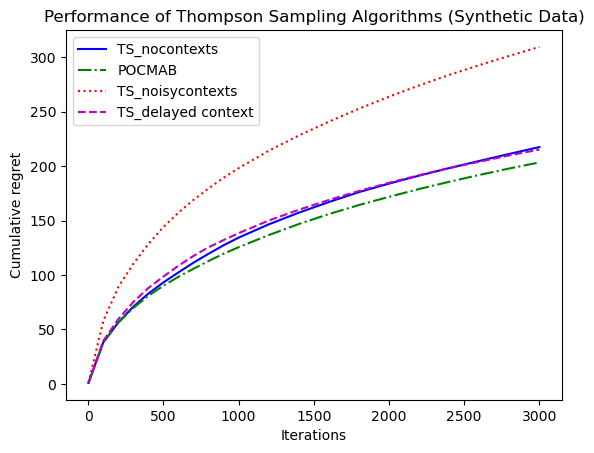

In [21]:
import matplotlib.pyplot as plt

class Experiments:

    def __init__(self):

        # Get parameters required
        synthetic_data = SyntheticDataGenerator()
        self.featuremap = synthetic_data.featuremap
        self.expected_featuremap = synthetic_data.expected_featuremap
        self.dim_context = synthetic_data.dim_context
        self.num_actions = synthetic_data.num_actions
        self.dim_action = synthetic_data.dim_action
        self.dim_theta = synthetic_data.dim_theta
        self.mean_contextdist, self.var_contextdist = synthetic_data.context_vectors()
        self.mean_contextnoise_prior, self.var_contextnoise_prior, self.var_contextnoise = synthetic_data.noisy_contexts()
        self.actions = synthetic_data.action_set()
        self.mean_theta, self.var_theta, self.reward_noise_mean, self.reward_noise_var = synthetic_data.reward_params()
        self.parameters = [self.mean_contextdist, self.var_contextdist, self.mean_contextnoise_prior, self.var_contextnoise_prior, self.var_contextnoise, self.actions, self.mean_theta, self.var_theta, self.reward_noise_mean, self.reward_noise_var]
        
        # Get functions required
        parameter_functions = ParameterFunctions()
        self.predicted_context = parameter_functions.predicted_context
        self.action_choice = parameter_functions.action_choice
        self.action_choice_noisy = parameter_functions.action_choice_noisy
        self.parameters_inverselikelihood = parameter_functions.parameters_inverselikelihood
        self.predicted_rewardparameter = parameter_functions.predicted_rewardparameter
        self.predicted_rewardparameter_doubleTS = parameter_functions.predicted_rewardparameter_doubleTS
        self.predicted_rewardparameter_noisy = parameter_functions.predicted_rewardparameter_noisy
        self.predicted_context_delayed = parameter_functions.predicted_context_delayed
        self.parameters_gamma_given_contexthist_delayed = parameter_functions.parameters_gamma_given_contexthist_delayed
        self.parameters_chat_given_gamma = parameter_functions.parameters_chat_given_gamma

        # Get UCB parameters
        #UCB = AlgorithmsUCB(self.parameters)
        #self.alpha = UCB.alpha
        #self.generate_reward = UCB.generate_reward

        # Get TS parameters
        TS = AlgorithmsTS(self.parameters)
        
        # Set number of experiments to run
        self.num_experiments = 150

        # Set iterations list to record results for
        self.iterations_list = [1,100,  200, 300, 400, 500,600,700,800,900,1000,1200,1400,1600,1800,2000,2200,2400,2600,2800,3000]
        self.max_iters = max(self.iterations_list)
        
    def run_experiments(self):
        """Run the experiments using the various algorithms and records results."""

        T = self.max_iters

        regret_iteration_denoise = []
        regret_iteration_pocmab = []
        regret_iteration_noisy = []
        regret_iteration_delayed = []
        regret_iteration_cdistr = []

        #regret_iteration_ucbnoisefree = []
        #regret_iteration_ucbnoisy = []
        #regret_iteration_ucbdenoise = []

        sd_iteration_denoise = []
        sd_iteration_pocmab = []
        sd_iteration_noisy = []
        sd_iteration_delayed = []
        sd_iteration_cdistr = []

        #sd_iteration_ucbnoisefree = []
        #sd_iteration_ucbnoisy = []
        #sd_iteration_ucbdenoise = []

        # Get TS algorithms
        doubleThompsonSampling_denoising = AlgorithmsTS.doubleThompsonSampling_denoising
        ThompsonSampling_POCMAB = AlgorithmsTS.ThompsonSampling_POCMAB
        ThompsonSampling_noisycontexts = AlgorithmsTS.ThompsonSampling_noisycontexts
        ThompsonSampling_delayedcontext = AlgorithmsTS.ThompsonSampling_delayedcontext
        ThompsonSampling_contextdistributions = AlgorithmsTS.ThompsonSampling_contextdistributions

        # Get UCB algorithms
        #UCB_noisefree = AlgorithmsUCB.UCB_noisefree
        #UCB_noisy = AlgorithmsUCB.UCB_noisycontext
        #UCB_denoise = AlgorithmsUCB.UCB_denoisecontext

        # arrays for cumulative regret at each interval
        experiments_regret_denoise = []
        experiments_regret_pocmab  = []
        experiments_regret_noisy  = []
        experiments_regret_delayed = []
        experiments_regret_cdistr = []

        #experiments_regret_UCBnoisefree = []
        #experiments_regret_UCBnoisy = []
        #experiments_regret_UCBdenoise = []

        theta_seeds = [i for i in range (100, 100 + 1 * self.num_experiments, 1)] # theta_true seed to change each experiment
        gamma_seeds = [i for i in range(200, 200 + 1 * self.num_experiments, 1)]
        context_completelist = np.random.multivariate_normal(self.mean_contextdist, self.var_contextdist,T)

        # cumulative regret arrays for each experiment
        for n in range(self.num_experiments):

            np.random.seed(gamma_seeds[n])
            gamma_true = np.random.multivariate_normal(self.mean_contextnoise_prior, self.var_contextnoise_prior)

            #generate synthetic contexts and noisy contexts
            
            noisycontext_completelist = [np.random.multivariate_normal(context_completelist[k]+gamma_true, self.var_contextnoise) for k in np.arange(T)]

            context_list = context_completelist[0:T]
            noisycontext_list = noisycontext_completelist[0:T]
                
            # get cumulative regret arrays for every iteration up to t
            experiments_regret_denoise.append(doubleThompsonSampling_denoising(self, T, self.parameters, context_list, noisycontext_list, theta_seeds[n], gamma_seeds[n]))
            experiments_regret_pocmab.append(ThompsonSampling_POCMAB(self, T, self.parameters, context_list, noisycontext_list, theta_seeds[n], gamma_seeds[n]))
            experiments_regret_noisy.append(ThompsonSampling_noisycontexts(self, T, self.parameters, context_list, noisycontext_list, theta_seeds[n], gamma_seeds[n]))
            experiments_regret_delayed.append(ThompsonSampling_delayedcontext(self, T, self.parameters, context_list, noisycontext_list, theta_seeds[n], gamma_seeds[n]))
            experiments_regret_cdistr.append(ThompsonSampling_contextdistributions(self, T, self.parameters, context_list, noisycontext_list, theta_seeds[n], gamma_seeds[n]))
            
            #experiments_regret_UCBnoisefree.append(UCB_noisefree(self, T, self.parameters, theta_seeds[n], gamma_seeds[n]))
            #experiments_regret_UCBnoisy.append(UCB_noisy(self, T, self.parameters, theta_seeds[n], gamma_seeds[n]))
            #experiments_regret_UCBdenoise.append(UCB_denoise(self, T, self.parameters, theta_seeds[n], gamma_seeds[n]))
            
            print("Experiment=", (n+1))

        # Standard deviations for TS
        for i in self.iterations_list:
            cumulative_regret_sum = 0
            for n in range(self.num_experiments):
                cumulative_regret_sum += experiments_regret_denoise[n][i-1]
            average_regret = cumulative_regret_sum / self.num_experiments
            print(f"Average regret_denoise at iteration {i}: {average_regret}")
            regret_iteration_denoise.append(average_regret)

            # calc. s.d.
            cum_regret_minus_mean_sqrd = 0
            for n in range(self.num_experiments):
                cum_regret_minus_mean_sqrd += (experiments_regret_denoise[n][i-1] - average_regret)**2
            sd_regret = np.sqrt((cum_regret_minus_mean_sqrd)/(self.num_experiments - 1))
            sd_iteration_denoise.append(sd_regret)

        for i in self.iterations_list:
            cumulative_regret_sum = 0
            for n in range(self.num_experiments):
                cumulative_regret_sum += experiments_regret_pocmab[n][i-1]
            average_regret = cumulative_regret_sum / self.num_experiments
            print(f"Average regret_pocmab at iteration {i}: {average_regret}")
            regret_iteration_pocmab.append(average_regret)

            # calc. s.d.
            cum_regret_minus_mean_sqrd = 0
            for n in range(self.num_experiments):
                cum_regret_minus_mean_sqrd += (experiments_regret_pocmab[n][i-1] - average_regret)**2
            sd_regret = np.sqrt((cum_regret_minus_mean_sqrd)/(self.num_experiments - 1))
            sd_iteration_pocmab.append(sd_regret)

        for i in self.iterations_list:
            cumulative_regret_sum = 0
            for n in range(self.num_experiments):
                cumulative_regret_sum += experiments_regret_noisy[n][i-1]
            average_regret = cumulative_regret_sum / self.num_experiments
            print(f"Average regret_noisy at iteration {i}: {average_regret}")
            regret_iteration_noisy.append(average_regret)

             # calc. s.d.
            cum_regret_minus_mean_sqrd = 0
            for n in range(self.num_experiments):
                cum_regret_minus_mean_sqrd += (experiments_regret_noisy[n][i-1] - average_regret)**2
            sd_regret = np.sqrt((cum_regret_minus_mean_sqrd)/(self.num_experiments - 1))
            sd_iteration_noisy.append(sd_regret)

        for i in self.iterations_list:
            cumulative_regret_sum = 0
            for n in range(self.num_experiments):
                cumulative_regret_sum += experiments_regret_delayed[n][i-1]
            average_regret = cumulative_regret_sum / self.num_experiments
            print(f"Average regret_delayed at iteration {i}: {average_regret}")
            regret_iteration_delayed.append(average_regret)

            # calc. s.d.
            cum_regret_minus_mean_sqrd = 0
            for n in range(self.num_experiments):
                cum_regret_minus_mean_sqrd += (experiments_regret_delayed[n][i-1] - average_regret)**2
            sd_regret = np.sqrt((cum_regret_minus_mean_sqrd)/(self.num_experiments - 1))
            sd_iteration_delayed.append(sd_regret)

        for i in self.iterations_list:
            cumulative_regret_sum = 0
            for n in range(self.num_experiments):
                cumulative_regret_sum += experiments_regret_cdistr[n][i-1]
            average_regret = cumulative_regret_sum / self.num_experiments
            print(f"Average regret_cdistr at iteration {i}: {average_regret}")
            regret_iteration_cdistr.append(average_regret)

            # calc. s.d.
            cum_regret_minus_mean_sqrd = 0
            for n in range(self.num_experiments):
                cum_regret_minus_mean_sqrd += (experiments_regret_cdistr[n][i-1] - average_regret)**2
            sd_regret = np.sqrt((cum_regret_minus_mean_sqrd)/(self.num_experiments - 1))
            sd_iteration_cdistr.append(sd_regret)

        # Standard deviations for UCB
        #for i in self.iterations_list:
        #    cumulative_regret_sum = 0
        ##    for n in range(self.num_experiments):
         #       cumulative_regret_sum += experiments_regret_UCBnoisefree[n][i-1]
         #   average_regret = cumulative_regret_sum / self.num_experiments
          #  print(f"Average regret_UCBnoisefree at iteration {i}: {average_regret}")
         #   regret_iteration_ucbnoisefree.append(average_regret)

            # calc. s.d.
          #  cum_regret_minus_mean_sqrd = 0
         #   for n in range(self.num_experiments):
          #      cum_regret_minus_mean_sqrd += (experiments_regret_UCBnoisefree[n][i-1] - average_regret)**2
            ##sd_regret = np.sqrt((cum_regret_minus_mean_sqrd)/(self.num_experiments - 1))
            #sd_iteration_ucbnoisefree.append(sd_regret)

        #for i in self.iterations_list:
            #cumulative_regret_sum = 0
            #for n in range(self.num_experiments):
             #   cumulative_regret_sum += experiments_regret_UCBnoisy[n][i-1]
            #average_regret = cumulative_regret_sum / self.num_experiments
            #print(f"Average regret_UCBnoisy at iteration {i}: {average_regret}")
            #regret_iteration_ucbnoisy.append(average_regret)

            # calc. s.d.
            #cum_regret_minus_mean_sqrd = 0
            #for n in range(self.num_experiments):
                #cum_regret_minus_mean_sqrd += (experiments_regret_UCBnoisy[n][i-1] - average_regret)**2
            #sd_regret = np.sqrt((cum_regret_minus_mean_sqrd)/(self.num_experiments - 1))
            #sd_iteration_ucbnoisy.append(sd_regret)

        #for i in self.iterations_list:
            #cumulative_regret_sum = 0
            #for n in range(self.num_experiments):
                #cumulative_regret_sum += experiments_regret_UCBdenoise[n][i-1]
            #average_regret = cumulative_regret_sum / self.num_experiments
            #print(f"Average regret_UCBdenoise at iteration {i}: {average_regret}")
            #regret_iteration_ucbdenoise.append(average_regret)

            # calc. s.d.
            #cum_regret_minus_mean_sqrd = 0
            #for n in range(self.num_experiments):
             #   cum_regret_minus_mean_sqrd += (experiments_regret_UCBdenoise[n][i-1] - average_regret)**2
            #sd_regret = np.sqrt((cum_regret_minus_mean_sqrd)/(self.num_experiments - 1))
            #sd_iteration_ucbdenoise.append(sd_regret)

        return regret_iteration_denoise, regret_iteration_pocmab, regret_iteration_noisy, regret_iteration_delayed, regret_iteration_cdistr, sd_iteration_denoise, sd_iteration_pocmab, sd_iteration_noisy, sd_iteration_delayed, sd_iteration_cdistr
    def plot(self):
        """Plots results."""

        regret_iteration_denoise, regret_iteration_pocmab, regret_iteration_noisy, regret_iteration_delayed, regret_iteration_cdistr,  sd_iteration_denoise, sd_iteration_pocmab, sd_iteration_noisy, sd_iteration_delayed, sd_iteration_cdistr=self.run_experiments()
        y_p_error_denoise = [x + y for x, y in zip(regret_iteration_denoise, sd_iteration_denoise)]
        y_p_error_pocmab = [x + y for x, y in zip(regret_iteration_pocmab, sd_iteration_pocmab)]
        y_p_error_noisy = [x + y for x, y in zip(regret_iteration_noisy, sd_iteration_noisy)]
        y_p_error_delayed = [x + y for x, y in zip(regret_iteration_delayed, sd_iteration_delayed)]

        y_m_error_denoise = [x - y for x, y in zip(regret_iteration_denoise, sd_iteration_denoise)]
        y_m_error_pocmab = [x - y for x, y in zip(regret_iteration_pocmab, sd_iteration_pocmab)]
        y_m_error_noisy = [x - y for x, y in zip(regret_iteration_noisy, sd_iteration_noisy)]
        y_m_error_delayed = [x - y for x, y in zip(regret_iteration_delayed, sd_iteration_delayed)]

        with open('regret_output_13Oct_8_2.txt', 'w') as file:
            file.write(str(self.iterations_list))
            file.write(str(self.parameters))
            for item in regret_iteration_denoise:
                file.write(f"regret_iteration_denoise: {item}\n")
            for item in regret_iteration_pocmab:
                file.write(f"regret_iteration_pocmab: {item}\n")
            for item in regret_iteration_noisy:
                file.write(f"regret_iteration_noisy: {item}\n")
            for item in regret_iteration_delayed:
                file.write(f"regret_iteration_delayed: {item}\n")  
            for item in regret_iteration_cdistr:
                file.write(f"regret_iteration_cdistr: {item}\n")  
            #for item in regret_iteration_ucbnoisefree:
               # file.write(f"regret_iteration_ucbnoisefree: {item}\n")  
            #for item in regret_iteration_ucbnoisy:
                #file.write(f"regret_iteration_ucbnoisy: {item}\n")  
            #for item in regret_iteration_ucbdenoise:
                #file.write(f"regret_iteration_ucbdenoise: {item}\n")  
            
        #with open('sd_output.txt', 'w') as file:
            #file.write(self.iterations_list)
            #for item in sd_iteration_denoise:
                #file.write(f"sd_iteration_denoise: {item}\n")
            #for item in sd_iteration_pocmab:
                #file.write(f"sd_iteration_pocmab: {item}\n")
            #for item in sd_iteration_noisy:
                #file.write(f"sd_iteration_noisy: {item}\n")
            #for item in sd_iteration_delayed:
                #file.write(f"sd_iteration_delayed: {item}\n")
            #for item in sd_iteration_cdistr:
                #file.write(f"sd_iteration_cdistr: {item}\n")
            #for item in sd_iteration_ucbnoisefree:
                #file.write(f"sd_iteration_ucbnoisefree: {item}\n")  
            #for item in sd_iteration_ucbnoisy:
                #file.write(f"sd_iteration_ucbnoisy: {item}\n")  
            #for item in sd_iteration_ucbdenoise:
                #file.write(f"sd_iteration_ucbdenoise: {item}\n")        
        
        plt.figure("TS Comparison")
        #plt.plot(self.iterations_list, regret_iteration_denoise,'b', self.iterations_list, regret_iteration_pocmab,'g', self.iterations_list, regret_iteration_noisy,'r', self.iterations_list, regret_iteration_delayed, 'm', self.iterations_list, regret_iteration_cdistr, 'y')
        #plt.legend(['Double TS','POCMAB','TS with noisy contexts','TS with delayed context', 'TS with context distribution only'])
        plt.plot(self.iterations_list, regret_iteration_denoise,'b', self.iterations_list, regret_iteration_pocmab,'g-.', self.iterations_list, regret_iteration_noisy,'r:', self.iterations_list, regret_iteration_delayed, 'm--')
        plt.legend(['TS_nocontexts','POCMAB','TS_noisycontexts','TS_delayed context'])
        plt.xlabel('Iterations')
        plt.ylabel('Cumulative regret')
        plt.title("Performance of Thompson Sampling Algorithms (Synthetic Data)")
        plt.savefig('synresults_TS_13Oct_8_2.png')

        # Compare UCB algorithms
        #plt.figure("UCB Comparison")
        #plt.plot(self.iterations_list, regret_iteration_ucbnoisefree, 'c', self.iterations_list, regret_iteration_ucbnoisy, 'r', self.iterations_list, regret_iteration_ucbdenoise, 'b')
        #plt.legend(['UCB with true context', 'UCB with noisy context', 'UCB with denoising'])
        #plt.xlabel('Iterations')
        #plt.ylabel('Cumulative regret')
        #plt.title("Performance of UCB Algorithms (Synthetic Data)")
        #plt.savefig('synresults_UCB.png')
        #plt.show()

experiments = Experiments()
experiments.plot()
